In [21]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

import numpy as np
import pandas as pd 
import json

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import random
import wandb

import sys
sys.path.append('/home/inaki/host_data')
import models
from utils import train_loop, evaluate, evaluate_kfold_ensemble
from CreateDataset import BertDataset

In [22]:
!cat ~/.local/share/jupyter/runtime/jpserver-1.json
# http://g4.etsisi.upm.es:8898/?token=

{
  "base_url": "/",
  "hostname": "0.0.0.0",
  "password": false,
  "pid": 1,
  "port": 8888,
  "root_dir": "/home/inaki",
  "secure": false,
  "sock": "",
  "token": "1aa98958da3d1bf5a308ddc86d070810423f9a55ce4f9446",
  "url": "http://be864635581a:8888/",
  "version": "2.14.0"
}

In [23]:
!nvidia-smi

Sun May 12 10:26:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8              23W / 370W |   9113MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [24]:
########################################
#                Ideas                 #
########################################

# Data Augmentation

    # Otros metodos 
        # Easy methods
        #     Synonym Replacement  |  Random synonym Insertion   |   Random Swap   |    Random Deletion
        # Albumentation (libreria)
        # Libreria para muchos de estos métodos  -  NLPAug 
        

    # Aumentado sobre embedding
        # Añadir ruido gaussiano
        # Ruido adversial
        # MixUp  (mezclar embedding y su label en la proporcion dada por una funcion)
        
    # Consistency regularization ??
    

# TO DO tutorias
    

    # Contrastive Loss
        # L2 normalization de los embbedings segun el paper (¿ no dice cuanto asi que suponemos 1 x norma L2 ?)
        # Probar decay de scl

    # Remplazo de sinonimos
    
    # Arreglar loss en Evaluate (Esta haciendo solo la cross-entropy)

    # Tecnicas basicas de data aumentacion
        # Round Trip transltion
        # MixUp
        # Ruido gaussiano

    # Volver a probar aumentado de datos con llama3
        
    # Probar CLS en vez de Mean Pooling ?


# Probar otros modelos

# ----------
    # Analizar matriz de confusion sobre baseline
    # Bert ajustado para mensajes de redes sociales (telegram)
    # investigar Equilibrado transformers
    
# Recently DONE
    # implementar MixUp

    # Contrastive Loss
        # Implementar yo el contrastive learning.  Probar con vectores muy sencillos a mano. revisar detach. cambiar a torch.
        # Dividir entre numero de elementos en el batch ??
        # Revisar formula paper y mirar mi codigo
        # Ir aplicando a modo de prueba todos los pasos con un batch de vectores muy sencillos.
        # Añado SWAP. SCL en dos fases, primero solo con contrastive loss y luego con BCE

    # Añadir model.eval() en evaluate para que el dropout funcione adecuadamente en test

    # devolver los logits y no la prediccion (y cambiar el BCE por el de logits)
    # Añadir capa densa entre el bert y las neuronas de clasificacion
    
# DONE
    # Investigar *Supervised Contrastive learning 
    # Traduir dataset español y probar
    # Aumentado de datos con llama3 

    # Guardar modelos para probar forma de ensembles
    # Baseline 10 folds sobre test, para tener 10 test como al probar 10 ensembles
    # Plotear distribucion de errores
    # implementar Predicciones 0, 1 o no lo se
    # Matriz de confusion
    # probar los k modelos sobre test
    # Guardar ultimo epoch de validacion, quitar MCC cada epoch, gaurdar media y desviacion del ultimo
    # Mirar si tiene emojis y traducirlos a texto (emojify)

    #  ¿¿¿ #os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8" ???
       # ERROR  # torch.use_deterministic_algorithms(True)  
    # guardar los resultados weight and bias o ML flow
    # Intentar guardar el MCC de cada fold para poder sacar desviaciones
    # Guardar semilas.  La semilla es para que los datos sean los mismos.
    # MCC  poner etiquetas a 1 y 2  ¿¿¿ seguro ???
    # Arreglar docker
    # sacar 10% de datos del dataset como sanity-check 
    # split stratify   (sklearn viene)
    # cross validation (sklearn)

In [25]:
###############################
#       configuración         #
###############################
MODEL_NAME = "BertBasePooledOutput"
EVALUATE_FREQ = 'END' # 'EVERY_EPOCH'

MAX_LENGTH = 512
HEAD_DROPOUT = 0.0
DATA_AUGMENTATION = [] #["Oversampling"] # '_es_into_en' # 'llama_aug'
FOLDS_NUM = 10

NUM_EPOCHS = 7
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
DECAY = 0
SWAP = 3
ALFA = 0.2

LOSS_FN =  'MixUp' # 'cross_entropy' # 'supervised_contrastive' #  'MixUp'  # 'MixUp_SCL'

temperature = 0.3  # temprature for contrastive loss
lam = 1  # lambda for loss

checkoint_folder = 'Baseline'

datadir = "/home/inaki/host_data/dataset_oppositional/"
cuda_device = 1
wandb_project = 'epoch_analysis'    # 'BASELINE'  'Ensemble_baseline'  'trash'  'epoch_analysis'

In [26]:
# Cargamos los datasets de entrenamiento y test
train_en_dataset_path = datadir + "train_en_data.pth"
test_en_dataset_path = datadir + "test_en_data.pth"
train_es_dataset_path = datadir + "train_es_data.pth"
test_es_dataset_path = datadir + "test_es_data.pth"

# Dataset traducido por llama3 8B
train_es_translated_path = datadir + "train_es_translated_data.pth"

# creamos los datasets de test
X, y = torch.load(test_es_dataset_path)
test_es_dataset = BertDataset(X, y)
X, y = torch.load(test_en_dataset_path)
test_en_dataset = BertDataset(X, y)

#Creamos dataloader de test
test_en_dataloader = DataLoader(test_en_dataset, batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
##################################
#     Weigths and bias Login    #
##################################
# MY API KEY
#    240062b42b3367d962eecb38802f856b41245735
wandb.login(key="240062b42b3367d962eecb38802f856b41245735")

for i in range(1):
    print(f"experimento {i}:")
    #####################
    #  Reproducibilidad #
    #####################
    SEED = random.randint(0,10000)
    print(f"seed: {SEED}")
    # fuente  -  https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True


    ######################################
    #          K-FOLD TRAIN LOOP         #
    ######################################

    # CROSS VALIDATION LOOP
    X, y = torch.load(train_en_dataset_path)
    X = np.array(X)
    y = np.array(y)

    if "_es_into_en" in DATA_AUGMENTATION:
        X_tr, y_tr = torch.load(train_es_translated_path)
        X_tr, y_tr = np.array(X_tr), np.array(y_tr)

    if "llama_aug" in DATA_AUGMENTATION:
        X_aug, y_aug = torch.load(datadir + "train_en_data_AUG_1-2.pth")
        X_aug, y_aug = np.array(X_aug), np.array(y_aug)


    skf = StratifiedKFold(n_splits=FOLDS_NUM, shuffle=True, random_state=42)

    k_test_outputs = []
    # Loop over the folds
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"fold {fold_idx + 1}")
        
        # Weigths and bias init
        config = {
        "MAX_LENGTH": MAX_LENGTH,
        "HEAD_DROPOUT": HEAD_DROPOUT,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "FOLDS_NUM": FOLDS_NUM,
        "NUM_EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "FOLD_IDX": fold_idx,
        "DATA_AUGMENTATION": DATA_AUGMENTATION,
        "LOSS_FN": LOSS_FN,
        "SEED": SEED
        }
        GROUP = f"{MODEL_NAME}_{HEAD_DROPOUT}_{BATCH_SIZE}_{LEARNING_RATE}_{DATA_AUGMENTATION}_{LOSS_FN}"
        if LOSS_FN == 'supervised_contrastive' or LOSS_FN == 'MixUp_SCL':
            GROUP += f"_{temperature}_{lam}"
            if DECAY != 0:
                GROUP += f"_dec-{DECAY}"
            if SWAP != 0:
                GROUP += f"_swap-{SWAP}"
        if LOSS_FN == 'MixUp' or LOSS_FN == 'MixUp_SCL':
            GROUP += f"_alfa-{ALFA}"
        wandb.init(project=wandb_project, group=GROUP, config=config)
        
        # Create the fold-specific train and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # mapeo indices de los originales a sus aumentaciones 1 a 2
        if "llama_aug" in DATA_AUGMENTATION:
            train_aug_idx = []
            for idx in train_index:
                train_aug_idx += [idx*2, idx*2 +1]  # Esto esta hardcodeado a que sea 1 a 2
            X_aug_train, y_aug_train = X_aug[train_aug_idx], y_aug[train_aug_idx]
            # Concateno los datos aumentados
            X_train_fold = np.concatenate((X_train_fold, X_aug_train))
            y_train_fold = np.concatenate((y_train_fold, y_aug_train))

        #El de entrenamiento le añado el dataset traducido
        if "_es_into_en" in DATA_AUGMENTATION:
            X_train_fold = np.concatenate((X_train_fold, X_tr))
            y_train_fold = np.concatenate((y_train_fold, y_tr))

        # MixUP
        if LOSS_FN == 'MixUp':
            # separamos el dataset entre positivos y negativos.  
            ###  ¡¡  OJO estamos usando tambien el aumentado de llama y el traducido  !!
            positive = BertDataset(X_train_fold[y_train_fold == 1], y_train_fold[y_train_fold == 1])
            negative = BertDataset(X_train_fold[y_train_fold == 0], y_train_fold[y_train_fold == 0])
            
        else:
            positive = None
            negative = None

        # Creo los datasets de entrenamiento y validación.
        train_en_dataset = BertDataset(X_train_fold, y_train_fold)
        val_en_dataset = BertDataset(X_val_fold, y_val_fold)
        
        # Create the train dataloader with a random oversampling of the minority class
        if "Oversampling" in DATA_AUGMENTATION:
            # Oversampling Train Dataloader
            labels = [sample[2] for sample in train_en_dataset]
            class_counts = torch.bincount(torch.tensor(labels))
            class_weights = 1.0 / class_counts.float()

            weights = [class_weights[label] for label in labels]
            sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_en_dataset), replacement=True)
            train_en_dataloader = DataLoader(train_en_dataset, sampler=sampler, batch_size=BATCH_SIZE)
            print(f"Oversampling")
        else:
            print(f"No Oversampling")
            train_en_dataloader = DataLoader(train_en_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
        val_en_dataloader = DataLoader(val_en_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Instanciamos el modelo cuya clase viene dada por la variable MODEL_NAME
        # Obtén la referencia a la clase del módulo models
        ModelClass = getattr(models, MODEL_NAME)
        model = ModelClass(dropout_prob=HEAD_DROPOUT)
        
        device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)
        
        # Paralelizamos el modelo si hay mas de una GPU
        if torch.cuda.device_count() > 5:
            model = nn.DataParallel(model, device_ids=[0, 1])
            
        # Define your loss function (binary cross-entropy in this case)
        criterion = nn.BCELoss()
          
        # Activamos todas las capas
        for param in model.parameters():
            param.requires_grad = True
        
        # Contmaos los parametros entrenables
        print(f"total params: {sum(p.numel() for p in model.parameters())} trainble params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
        

        # Define your optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        
        # Define your learning rate scheduler
        total_steps = len(train_en_dataloader) * NUM_EPOCHS
        warmup_steps = int(total_steps * 0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        
        # debug pytorch version of contrastive loss
        # from utils import test_contrastive_loss
        #test_contrastive_loss(model, train_en_dataloader, temperature, lam, device)

        # Train the model
        train_loop(model, train_en_dataloader, test_en_dataloader, positive, negative, optimizer, scheduler, NUM_EPOCHS, temperature, lam, DECAY, LOSS_FN, device, SWAP, ALFA, EVALUATE_FREQ)
        
        # Evaluate the model
        #_ = evaluate(model, val_en_dataloader, 0.5, device, val_or_test="Val")
        k_test_outputs += [evaluate(model, test_en_dataloader, 0.5, device, val_or_test="Test")]
        
        # Save the model
        torch.save(model.state_dict(), f"/home/inaki/host_data/checkpoints/{checkoint_folder}/{GROUP}_exp-{i}_fold_{fold_idx}.pth")
    evaluate_kfold_ensemble(k_test_outputs, test_en_dataloader)
        
    # bB - Finalizamos el experimento
    wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/inaki/.netrc


experimento 0:
seed: 5871
fold 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling
cuda:1
total params: 109483009 trainble params: 109483009


Epoch 1/7: 100%|██████████| 203/203 [02:29<00:00,  1.36batch/s, loss=0.64] 


Epoch 1, Average Train Loss: 0.5909188179840595
Test MCC 0.5 threshold:  0.6866
[[217  45]
 [ 16 122]]
Average Test Loss: 0.3840


Epoch 2/7: 100%|██████████| 203/203 [02:29<00:00,  1.35batch/s, loss=0.261]


Epoch 2, Average Train Loss: 0.41739697453423674
Test MCC 0.5 threshold:  0.7548
[[221  41]
 [  8 130]]
Average Test Loss: 0.3262


Epoch 3/7: 100%|██████████| 203/203 [02:29<00:00,  1.36batch/s, loss=0.341]


Epoch 3, Average Train Loss: 0.33366447129273064
Test MCC 0.5 threshold:  0.8067
[[244  18]
 [ 17 121]]
Average Test Loss: 0.2374


Epoch 4/7: 100%|██████████| 203/203 [02:29<00:00,  1.35batch/s, loss=0.225]


Epoch 4, Average Train Loss: 0.29954802101762423
Test MCC 0.5 threshold:  0.7788
[[228  34]
 [  9 129]]
Average Test Loss: 0.3165


Epoch 5/7: 100%|██████████| 203/203 [02:30<00:00,  1.35batch/s, loss=0.232]


Epoch 5, Average Train Loss: 0.26845496602980373
Test MCC 0.5 threshold:  0.7965
[[242  20]
 [ 17 121]]
Average Test Loss: 0.2686


Epoch 6/7: 100%|██████████| 203/203 [02:29<00:00,  1.35batch/s, loss=0.395] 


Epoch 6, Average Train Loss: 0.262536046576911
Test MCC 0.5 threshold:  0.8055
[[246  16]
 [ 19 119]]
Average Test Loss: 0.2629


Epoch 7/7: 100%|██████████| 203/203 [02:30<00:00,  1.35batch/s, loss=0.255]


Epoch 7, Average Train Loss: 0.26584293396014885
Test MCC 0.5 threshold:  0.8099
[[250  12]
 [ 22 116]]
Average Test Loss: 0.2698
Test MCC 0.5 threshold:  0.8098
[[251  11]
 [ 23 115]]
Average Test Loss: 0.2492
fold 2


Test_0.5_threshold_MCC,▁▅█▆▇███
Test_0.5_threshold_MCC,0.80984


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No Oversampling
cuda:1
total params: 109483009 trainble params: 109483009


Epoch 1/7: 100%|██████████| 203/203 [02:30<00:00,  1.35batch/s, loss=0.472]


Epoch 1, Average Train Loss: 0.5831560005108124
Test MCC 0.5 threshold:  0.7363
[[210  52]
 [  4 134]]
Average Test Loss: 0.3616


Epoch 2/7: 100%|██████████| 203/203 [02:29<00:00,  1.35batch/s, loss=0.267]


Epoch 2, Average Train Loss: 0.38903841956202034
Test MCC 0.5 threshold:  0.7862
[[235  27]
 [ 13 125]]
Average Test Loss: 0.2600


Epoch 3/7: 100%|██████████| 203/203 [02:30<00:00,  1.35batch/s, loss=0.189]


Epoch 3, Average Train Loss: 0.32707534113834646
Test MCC 0.5 threshold:  0.7877
[[247  15]
 [ 23 115]]
Average Test Loss: 0.2611


Epoch 4/7: 100%|██████████| 203/203 [02:29<00:00,  1.35batch/s, loss=0.268]


Epoch 4, Average Train Loss: 0.30125314349611404
Test MCC 0.5 threshold:  0.7871
[[250  12]
 [ 26 112]]
Average Test Loss: 0.2564


Epoch 5/7:  90%|████████▉ | 182/203 [02:14<00:15,  1.35batch/s, loss=0.337]

In [15]:
#### Bucle cargando todos los modelos BASELINE
baseline_test_outputs = []

# Filtramos los modelos que queremos evaluar
modelos = os.listdir("/home/inaki/host_data/checkpoints/Baseline/")
modelos = [m for m in modelos if m.startswith('BertBasePooledOutput_0.0_16_2e-05_[]_MixUp_alfa-0.3')]
# modelos = [m for m in modelos if m.startswith(GROUP)]

for model_path in modelos:
    model = ModelClass(dropout_prob=HEAD_DROPOUT)
    # Load the saved state dictionary into the initialized model
    
    state_dict = torch.load('/home/inaki/host_data/checkpoints/Baseline/' + model_path)
    # Remove the 'module.' prefix from keys if present (esto es por ser un modelo paralelizado)
    if 'module.' in list(state_dict.keys())[0]:
        state_dict = {key[7:]: value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    baseline_test_outputs += [evaluate(model, test_en_dataloader, 0.5, device, val_or_test="Test")]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7931
[[248  14]
 [ 23 115]]
Average Test Loss: 0.2455


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8214
[[250  12]
 [ 20 118]]
Average Test Loss: 0.2489


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7997
[[246  16]
 [ 20 118]]
Average Test Loss: 0.2366


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7989
[[248  14]
 [ 22 116]]
Average Test Loss: 0.2590


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7827
[[245  17]
 [ 22 116]]
Average Test Loss: 0.2569


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8104
[[248  14]
 [ 20 118]]
Average Test Loss: 0.2353


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8156
[[253   9]
 [ 24 114]]
Average Test Loss: 0.2465


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8326
[[251  11]
 [ 19 119]]
Average Test Loss: 0.2421


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.8393
[[248  14]
 [ 15 123]]
Average Test Loss: 0.2468


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Test MCC 0.5 threshold:  0.7885
[[245  17]
 [ 21 117]]
Average Test Loss: 0.2438


,mcc,low,up
80,0.817978,0.47,0.53
69,0.817978,0.46,0.53
58,0.817978,0.45,0.53
68,0.817497,0.46,0.52
79,0.817497,0.47,0.52
57,0.817497,0.45,0.52
67,0.817039,0.46,0.51
66,0.817039,0.46,0.50
77,0.817039,0.47,0.50
78,0.817039,0.47,0.51


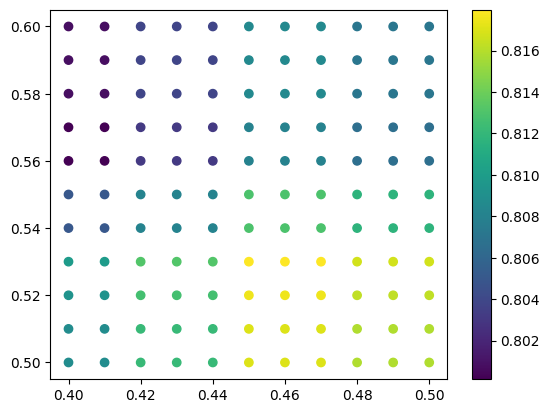

In [20]:
# Evaluamos el valor optimo para el threshold
test_true_labels = []
for data in test_en_dataloader:
    input_ids, attention_mask, labels, _ = data
    test_true_labels += labels.tolist()

all_mcc = []
threshold = []
low, up = [], []
test_outputs = np.array(baseline_test_outputs)
test_outputs = test_outputs.mean(axis=0)
for i in range(40, 51):
    for j in range(50, 61):
        test_mean_predictions = [0 if x < i/100 else (1 if x > j/100 else -1) for x in test_outputs]
        mcc = matthews_corrcoef(test_true_labels, test_mean_predictions)
        all_mcc += [mcc]
        low += [i/100]
        up += [j/100]
        # create a df with the results and sort by mcc

df = pd.DataFrame({'mcc':all_mcc, 'low':low, 'up':up})
df = df.sort_values('mcc', ascending=False)
# display all df
#pd.set_option('display.max_rows', None)
display(df.head(15))

# plot que representa en los ejes x e y los valores de low y up y en el eje z el mcc
plt.scatter(df['low'], df['up'], c=df['mcc'], cmap='viridis')
plt.colorbar()
plt.show()


In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>", raw=True)